# Requirements

In [ ]:
import pandas as pd

In [16]:
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, classification_report, mean_squared_error, mean_absolute_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_predict, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder
from xgboost import XGBClassifier, XGBRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import numpy as np

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


def missing_table(data: pd.DataFrame):
    statistics_missing_table = data.isnull().sum().reset_index().rename(columns={"index": "Feature", 0: "CountMissing"})
    percentage_missing = (
        (statistics_missing_table["CountMissing"] / len(data) * 100).reset_index()).reset_index().rename(
        columns={"CountMissing": "PercentageMissing"})
    statistics_missing_table["PercentageMissing"] = percentage_missing["PercentageMissing"]
    statistics_missing_table["Total"] = len(data)
    return statistics_missing_table


def balance_table(data: pd.DataFrame, target_column):
    balance_table = data.groupby(target_column).size().reset_index().rename(
        columns={target_column: "Class", 0: "Count"})
    tmp = (balance_table["Count"] / len(data) * 100).reset_index().rename(
        columns={target_column: "Class", "Count": "Percentage"})
    balance_table["Percentage"] = tmp["Percentage"]
    balance_table["Total"] = len(data)
    return balance_table


def get_numerical_features_names(data: pd.DataFrame):
    result_columns = []
    for column in data.columns:
        if pd.api.types.is_any_real_numeric_dtype(data[column]):
            result_columns.append(column)

    return result_columns


def get_categorical_features_names(data: pd.DataFrame, target_feature=None):
    categorical_features = []
    for column in data.columns:
        if target_feature is not None and column == target_feature:
            continue

        if not pd.api.types.is_any_real_numeric_dtype(data[column]):
            categorical_features.append(column)
    return categorical_features


def get_missing_features_name(data: pd.DataFrame):
    missing_values_features_names = []
    for column in data.columns:
        if len(data[data[column].isna()]) > 0:
            missing_values_features_names.append(column)
    return missing_values_features_names


def show_displots(data: pd.DataFrame, columns: list):
    for column in columns:
        sns.displot(data, x=column, kde=True)
        plt.show()


def show_displot_before_and_after_inputation(data_before: pd.DataFrame, data_after: pd.DataFrame, missing_feature_name):
    sns.displot(data_before[missing_feature_name], kde=True)
    plt.show()
    sns.displot(data_after[missing_feature_name], kde=True)
    plt.show()


def correlated_imputer(data: pd.DataFrame, correlated_columns: list, strategy="knn", n_neighbours=5):
    df_copy = data.copy()
    if strategy == "knn":
        knn_imputer = KNNImputer(n_neighbors=n_neighbours)
        normalizer = MinMaxScaler()
        normalized_values = normalizer.fit_transform(df_copy[correlated_columns])
        filled_with_knn = knn_imputer.fit_transform(normalized_values)
        imputed = normalizer.inverse_transform(filled_with_knn)
    elif strategy == "mice":
        mice = IterativeImputer()
        imputed = mice.fit_transform(df_copy[correlated_columns])

    df_copy[correlated_columns] = imputed

    return df_copy


def uncorrelated_imputer(data: pd.DataFrame, missing_feature: str, strategy="mean", const_value=-1):
    df_copy = data.copy()
    if strategy != "const":
        fill_value = getattr(df_copy[missing_feature], strategy)()
        if strategy == "mode":
            fill_value = fill_value[0]
        df_copy[missing_feature] = df_copy[missing_feature].fillna(fill_value)
    else:
        df_copy[missing_feature] = df_copy[missing_feature].fillna(const_value)
    return df_copy


def impute_data(data: pd.DataFrame, data_to_impute: list, strategies: list):
    if len(data_to_impute) != len(strategies):
        return "Differenet lengts"
    data_copy = data.copy()
    for impute_data, strategie in zip(data_to_impute, strategies):
        if strategie == "mice" or strategie == "knn":
            data_copy = correlated_imputer(data_copy, impute_data, strategie)
        else:
            if len(impute_data) != 1:
                return "Impute failed: Uncorrelated imputing with multiple data"
            data_copy = uncorrelated_imputer(data_copy, impute_data[0], strategie)
    return data_copy


def encode_data(data: pd.DataFrame, features_to_encode: list, strategy="ordinal", return_encoders=False):
    encoders = {}
    encoded_data = None
    if strategy == "ordinal" or strategy == "label":
        encoded_data, encoders = ordinal_encode_data(data, features_to_encode)
    elif strategy == "onehot":
        encoded_data, encoders = one_hot_encode_data(data, features_to_encode)

    if return_encoders:
        return encoded_data, encoders
    else:
        return encoded_data


def one_hot_encode_data(data: pd.DataFrame, features_to_encode: list):
    encoders = {}
    data_copy = data.copy()
    for feature in features_to_encode:
        feature_flags = pd.get_dummies(data_copy[feature])
        feature_flags = feature_flags.replace(True, 1)
        feature_flags = feature_flags.replace(False, 0)
        data_copy = data_copy.drop(columns=feature, axis=1)
        data_copy = pd.concat([data_copy, feature_flags], axis=1)
        encoders[feature] = list(feature_flags.columns)
    return data_copy, encoders


def ordinal_encode_data(data: pd.DataFrame, features_to_encode: list):
    encoders = {}
    data_copy = data.copy()
    for feature in features_to_encode:
        encoder = OrdinalEncoder()
        data_copy[[feature]] = encoder.fit_transform(data_copy[[feature]])
        encoders[feature] = encoder
    return data_copy, encoders


def scale_data(train, test, strategy="standard", features_to_scale=()):
    train_copy = train.copy()
    test_copy = test.copy()
    if len(features_to_scale) == 0:
        features_to_scale = get_numerical_features_names(train_copy)

    scaler = None
    if strategy == "standard":
        scaler = StandardScaler()

    elif strategy == "minmax":
        scaler = MinMaxScaler()

    scaler.fit(train_copy[features_to_scale])
    train_copy[features_to_scale] = scaler.transform(train_copy[features_to_scale])
    test_copy[features_to_scale] = scaler.transform(test_copy[features_to_scale])

    return train_copy, test_copy


def show_ba_displots_pairwise(data_before: pd.DataFrame, data_after: pd.DataFrame, features: list):
    for feature in features:
        show_displot_before_and_after_inputation(data_before, data_after, missing_feature_name=feature)


def to_time_series(data: pd.DataFrame, time_feature, auto_sort=True):
    data_copy = data.copy()
    data_copy[time_feature] = pd.to_datetime(data_copy[time_feature])
    data_copy = data_copy.set_index(time_feature)
    if auto_sort:
        return data_copy.sort_index()
    return data_copy


def correlation_map(data: pd.DataFrame, figsize=None):
    if figsize is not None:
        num_features = len(data.columns)
        if num_features <= 8:
            figsize = (12, 8)
        elif num_features <= 15:
            figsize = (20, 15)
        else:
            figsize = (28, 20)

    plt.figure(figsize=figsize)
    sns.heatmap(data[get_numerical_features_names(data)].corr(), annot=True)
    plt.show()


def auto_shift(data: pd.DataFrame, lag, features_to_shift: list, shifted_feature_name="*_prev_i", auto_drop_na=False,
               return_features=True):
    data_copy = data.copy()
    for i in range(1, lag + 1):
        for feature in features_to_shift:
            if shifted_feature_name == "*_prev_i":
                data_copy[f'{feature}_prev_{i}'] = data[feature].shift(i)
            else:
                data_copy[f'{shifted_feature_name}_{i}'] = data[feature].shift(i)

    if auto_drop_na:
        data_copy = data_copy.dropna(axis=0)

    if return_features:
        features = data_copy.columns.drop(features_to_shift)
        return data_copy, list(features)
    else:
        return data_copy


def regression_report(y_true, y_pred, include_mae=False):
    print("Regression Report:")
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"Mean Square Error: {mse}")
    if include_mae:
        mae = mean_absolute_error(y_true, y_pred)
        print(f"Mean Absolute Error: {mae}")
    print(f"R2 Score: {r2}")


def show_time_series_predicts(y_test, y_pred, figsize=(20, 10)):
    plt.figure(figsize=figsize)
    plt.plot(y_test.values, label='actual')
    plt.plot(y_pred, label='predicted')
    plt.legend()
    plt.show()

# Laboratory Exercise - Run Mode (8 points)

## Introduction
In this laboratory assignment, the focus is on time series forecasting, specifically targeting the prediction of the current **mean temperature** in the city of Delhi. Your task involves employing bagging and boosting methods to forecast the **mean temperature**. To accomplish this use data from the preceding three days, consisting of **mean temperature**, **humidity**, **wind speed**, and **mean pressure**.

**Note: You are required to perform this laboratory assignment on your local machine.**

## The Climate Dataset

## Downloading the Climate Dataset

In [1]:
!gdown 1kczX2FpFTH1QEsDeg6dszXM3Azwyd7XC # Download the dataset.

Downloading...
From: https://drive.google.com/uc?id=1kczX2FpFTH1QEsDeg6dszXM3Azwyd7XC
To: /content/climate-data.csv
100% 78.1k/78.1k [00:00<00:00, 2.69MB/s]


## Exploring the Climate Dataset
This dataset consists of daily weather records for the city of Delhi spanning a period of 4 years (from 2013 to 2017). The dataset includes the following attributes:

- date - date in the format YYYY-MM-DD,
- meantemp - mean temperature averaged from multiple 3-hour intervals in a day,
- humidity - humidity value for the day (measured in grams of water vapor per cubic meter volume of air),
- wind_speed - wind speed measured in kilometers per hour, and
- meanpressure - pressure reading of the weather (measured in atm).

*Note: The dataset is complete, with no missing values in any of its entries.*

Load the dataset into a `pandas` data frame.

In [9]:
# Write your code here. Add as many boxes as you need.
df = pd.read_csv("./climate-data(1).csv")
df

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


In [10]:
df_copy = to_time_series(df, time_feature="date", auto_sort=True)
df_copy

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...
2016-12-28,17.217391,68.043478,3.547826,1015.565217
2016-12-29,15.238095,87.857143,6.000000,1016.904762
2016-12-30,14.095238,89.666667,6.266667,1017.904762


Explore the dataset using visualizations of your choice.

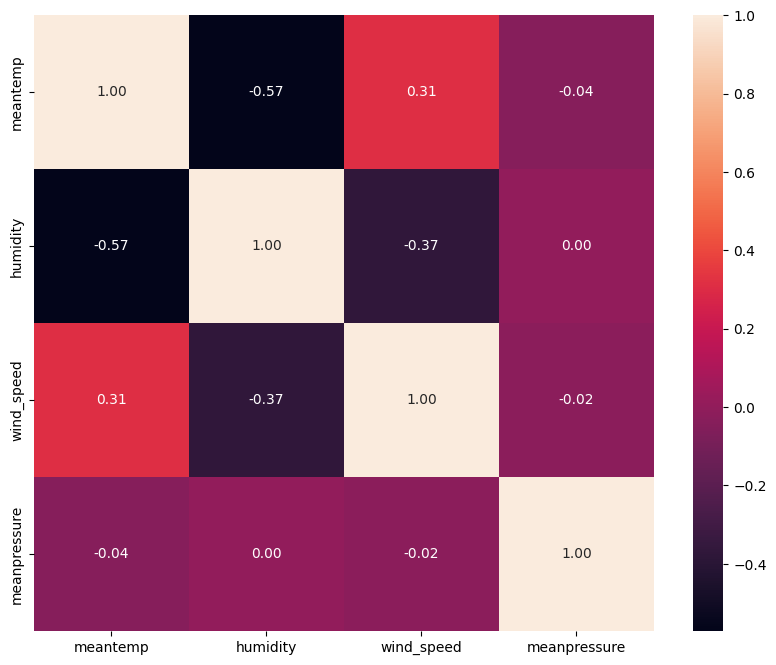

In [12]:
corr_matrix = df_copy.select_dtypes(include=[float, int]).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.show()

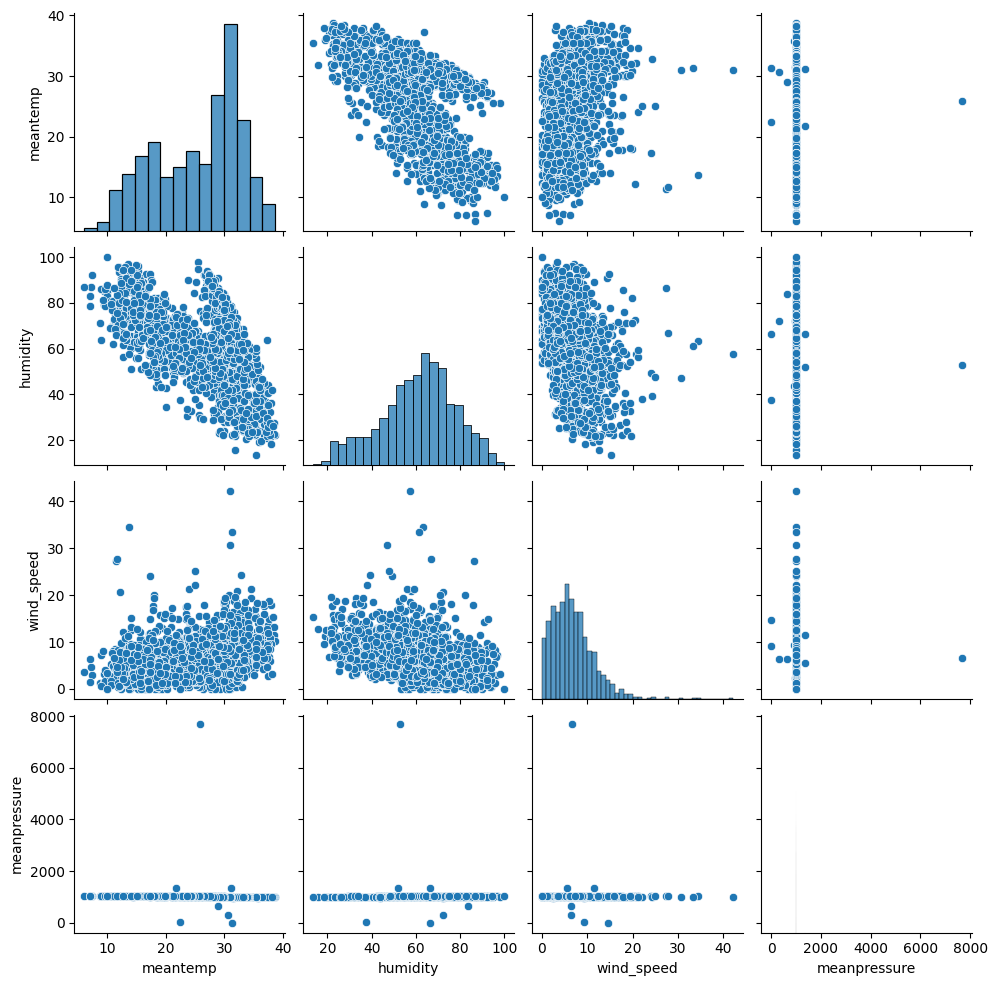

In [13]:
sns.pairplot(df_copy)

# Feauture Extraction
Apply a lag of one, two, and three days to each feature, creating a set of features representing the meteorological conditions from the previous three days. To maintain dataset integrity, eliminate any resulting missing values at the beginning of the dataset.

Hint: Use `df['column_name'].shift(period)`. Check the documentation at https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html.

In [17]:
# Write your code here. Add as many boxes as you need.
def get_numerical_features_names(data):
    result_columns = []
    for column in data.columns:
        if np.issubdtype(data[column].dtype, np.number):
            result_columns.append(column)
    return result_columns
df_copy_1, features = auto_shift(df_copy, lag=3, features_to_shift=get_numerical_features_names(df_copy), return_features=True,
                   auto_drop_na=True)
df_copy_1

,meantemp,humidity,wind_speed,meanpressure,meantemp_prev_1,humidity_prev_1,wind_speed_prev_1,meanpressure_prev_1,meantemp_prev_2,humidity_prev_2,wind_speed_prev_2,meanpressure_prev_2,meantemp_prev_3,humidity_prev_3,wind_speed_prev_3,meanpressure_prev_3
date,,,,,,,,,,,,,,,,
2013-01-04,8.666667,71.333333,1.233333,1017.166667,7.166667,87.000000,4.633333,1018.666667,7.400000,92.000000,2.980000,1017.800000,10.000000,84.500000,0.000000,1015.666667
2013-01-05,6.000000,86.833333,3.700000,1016.500000,8.666667,71.333333,1.233333,1017.166667,7.166667,87.000000,4.633333,1018.666667,7.400000,92.000000,2.980000,1017.800000
2013-01-06,7.000000,82.800000,1.480000,1018.000000,6.000000,86.833333,3.700000,1016.500000,8.666667,71.333333,1.233333,1017.166667,7.166667,87.000000,4.633333,1018.666667
2013-01-07,7.000000,78.600000,6.300000,1020.000000,7.000000,82.800000,1.480000,1018.000000,6.000000,86.833333,3.700000,1016.500000,8.666667,71.333333,1.233333,1017.166667
2013-01-08,8.857143,63.714286,7.142857,1018.714286,7.000000,78.600000,6.300000,1020.000000,7.000000,82.800000,1.480000,1018.000000,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-28,17.217391,68.043478,3.547826,1015.565217,16.850000,67.550000,8.335000,1017.200000,17.142857,74.857143,8.784211,1016.952381,14.000000,94.300000,9.085000,1014.350000
2016-12-29,15.238095,87.857143,6.000000,1016.904762,17.217391,68.043478,3.547826,1015.565217,16.850000,67.550000,8.335000,1017.200000,17.142857,74.857143,8.784211,1016.952381
2016-12-30,14.095238,89.666667,6.266667,1017.904762,15.238095,87.857143,6.000000,1016.904762,17.217391,68.043478,3.547826,1015.565217,16.850000,67.550000,8.335000,1017.200000


## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**



In [21]:
# Write your code here. Add as many boxes as you need.
X = df_copy_1[features]
Y = df_copy_1["meantemp"]
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,shuffle=False)

## Ensemble Learning Methods

### Bagging

Create an instance of a Random Forest model and train it using the `fit` function.

In [22]:
# Write your code here. Add as many boxes as you need.
rfr = RandomForestRegressor()
rfr.fit(x_train,y_train)

RandomForestRegressor()

Use the trained model to make predictions for the test set.

In [23]:
# Write your code here. Add as many boxes as you need.
rfr_pred = rfr.predict(x_test)

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [24]:
# Write your code here. Add as many boxes as you need.
regression_report(y_test,rfr_pred)

Regression Report:
Mean Square Error: 3.168035648097605
R2 Score: 0.9010963242009018


### Boosting

Create an instance of an XGBoost model and train it using the `fit` function.

In [25]:
# Write your code here. Add as many boxes as you need.
xgb = XGBRegressor(max_depth=4, random_state=0, n_estimators=200)
xgb.fit(x_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=200, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

Use the trained model to make predictions for the test set.

In [26]:
# Write your code here. Add as many boxes as you need.
xgb_pred = xgb.predict(x_test)

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [27]:
# Write your code here. Add as many boxes as you need.
regression_report(y_test,xgb_pred)

Regression Report:
Mean Square Error: 4.071187700824077
R2 Score: 0.8729006004962812


# Laboratory Exercise - Bonus Task (+ 2 points)

Define the forecasting model using the **Keras Sequential API** (`keras.models.Sequential`), incorporating one or more LSTM layers along with additional relevant layers (`keras.layers`). Be cautious when specifying the configuration of the final layer to ensure proper model output for the forecasting task.

In [30]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler


ModuleNotFoundError: No module named 'tensorflow'

In [32]:
pip install tensorflow

  Using cached tensorflow-2.11.0-cp37-cp37m-win_amd64.whl.metadata (2.5 kB)
  Using cached tensorflow_intel-2.11.0-cp37-cp37m-win_amd64.whl.metadata (3.9 kB)
Using cached tensorflow-2.11.0-cp37-cp37m-win_amd64.whl (1.9 kB)
   ---------------------------------------- 266.3/266.3 MB 1.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [Errno 28] No space left on device

